# Heisenberg XXX model

$$ H_{\text{TFIM}} = \sum_{j=1}^{L}(X_jX_{j+1}+Y_jY_{j+1}+Z_jZ_{j+1}) $$

pip install qrisp 

https://www.qrisp.eu


In [1]:
import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import svds

# Create a graph
L = 12
G = nx.Graph()
G.add_edges_from([(k,k+1) for k in range(L-1)]) 
#nx.draw(G, with_labels=True)

## Define Heisenberg Hamiltonian

In [2]:
from qrisp.operators import X, Y, Z

def create_heisenberg_hamiltonian(G):
    H = sum(X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j) for (i,j) in G.edges())
    return H

H = create_heisenberg_hamiltonian(G)
print(H)

X(0)*X(1) + X(1)*X(2) + X(10)*X(11) + X(2)*X(3) + X(3)*X(4) + X(4)*X(5) + X(5)*X(6) + X(6)*X(7) + X(7)*X(8) + X(8)*X(9) + X(9)*X(10) + Y(0)*Y(1) + Y(1)*Y(2) + Y(10)*Y(11) + Y(2)*Y(3) + Y(3)*Y(4) + Y(4)*Y(5) + Y(5)*Y(6) + Y(6)*Y(7) + Y(7)*Y(8) + Y(8)*Y(9) + Y(9)*Y(10) + Z(0)*Z(1) + Z(1)*Z(2) + Z(10)*Z(11) + Z(2)*Z(3) + Z(3)*Z(4) + Z(4)*Z(5) + Z(5)*Z(6) + Z(6)*Z(7) + Z(7)*Z(8) + Z(8)*Z(9) + Z(9)*Z(10)


## Calculate eigenvalues clasically

In [3]:
M = H.to_sparse_matrix()
eigenvalues, eigenvectors = eigsh(M, k=1, which='SA')
E0 = eigenvalues[0]

# Rescale to E0=0
H2 = H - E0

M = H2.to_sparse_matrix()
u, s, vt = svds(M, k=1, which='LM')
spectral_norm = s[0]

E_max = spectral_norm

# Rescale such that spectrum in [0,1)
H3 = H2*(1/(E_max+1))

M = H3.to_sparse_matrix()
eigenvalues, eigenvectors = eigsh(M, k=2, which='SA')

# ground state
psi0 = eigenvectors[:,0]

E0 = eigenvalues[0]
E1 = eigenvalues[1]

delta = E1-E0
print('Spectral gap:', delta)

Spectral gap: 0.03450498262338093


## VQE warm start 

* 2 layers of problem specific Ansatz: https://arxiv.org/abs/2108.08086, https://qrisp.eu/reference/Algorithms/vqe/vqeProblems/heisenberg.html

In [4]:
from qrisp import QuantumVariable
from qrisp.vqe.problems.heisenberg import *
from qrisp import QPE

vqe = heisenberg_problem(G,1,0)
U_0 = vqe.train_function(QuantumVariable(G.number_of_nodes()),depth=1,max_iter=100)

qv = QuantumVariable(G.number_of_nodes())
U_0(qv)
E_0 = H3.get_measurement(qv,precision=0.001)
print(E_0)

psi = qv.qs.statevector_array()

F0 = np.abs(np.dot(psi.conj().transpose(),psi0))**2
print('Fidelity:', F0)

/Users/renezander/Desktop/Qrisp/src/qrisp/operators/qubit/qubit_operator.py:1570: UserWarning: DeprecationWarning: This method will no longer be supported in a later release of Qrisp. Instead please migrate to .expectation_value.
  warnings.warn("DeprecationWarning: This method will no longer be supported in a later release of Qrisp. Instead please migrate to .expectation_value.")


0.02927102399277143                                                                  
Fidelity: 0.8386095714975849                                                         


## QPE

Recall that $n+\lceil \log(2+\frac{1}{2\epsilon})\rceil$ precision qubits for QPE yield an estimate accurate to $n$ bits with probability $1-\epsilon$.

In [5]:

qv = QuantumVariable(G.number_of_nodes())
U_0(qv)

# Hamiltonian simulation via first second Suzuki-Trotter formula with 2 steps 
exp_H = H3.trotterization(order=2,forward_evolution=False)

qpe_res = QPE(qv,exp_H,precision=5,kwargs={"t":2*np.pi,"steps":2},iter_spec=True)

qc = qpe_res.qs.compile()
tqc = qc.transpile(basis_gates=["cz","u"])

print(qc.count_ops())
print(tqc.count_ops())
print(tqc.num_qubits())
print(tqc.depth())

{'x': 12, 'h': 3879, 'p': 175, 'cx': 14838, 'rz': 7958, 'sx': 2057, 'sx_dg': 2057, 'QFT_dg': 1, 'gphase': 1}
{'u3': 25677, 'cz': 14864}
17
15944


## Ground state is prepared if qpe_res is in |0> state

In [7]:
results = qpe_res.get_measurement(precompiled_qc=qc)
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
P0 = sorted_results[0]
print('Success probability:', P0)

qc = qpe_res.qs.compile()

n = H.find_minimal_qubit_amount()

for i in range(qc.num_qubits() - n):
    qc.qubits.insert(0, qc.qubits.pop(-1))

phi = qc.statevector_array()[:2**n]
phi = phi/np.linalg.norm(phi)

F0 = (np.abs(np.dot(phi.conj().transpose(),psi0))**2)
print('Fidelity:', F0)

Success probability: 0.8095                                                          
Fidelity: 0.9997542093497374                                                         


# Benchmarking

In [ ]:
def prepare_gs(precision, steps, results_dict):

    result = dict()

    qv = QuantumVariable(G.number_of_nodes())
    U_0(qv)

    # Hamiltonian simulation via first order Suzuki-Trotter formula with 5 steps 
    # Note: 5 steps are insufficient to obtain the ground state energy within error 0.1 (10 steps are sufficent)
    exp_H = H3.trotterization(order=2,forward_evolution=False)

    qpe_res = QPE(qv,exp_H,precision=precision,kwargs={"t":2*np.pi,"steps":steps},iter_spec=True)

    qc = qpe_res.qs.compile()
    tqc = qc.transpile(basis_gates=["cz","u"])

    result["ops"] = tqc.count_ops()
    result["depth"] = tqc.depth()

    results = qpe_res.get_measurement(precompiled_qc=qc)
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
    P0 = sorted_results[0]
    #print('Success probability:', P0)
    result["P0"] = P0

    #qc = qpe_res.qs.compile()

    n = H.find_minimal_qubit_amount()

    for i in range(qc.num_qubits() - n):
        qc.qubits.insert(0, qc.qubits.pop(-1))

    phi = qc.statevector_array()[:2**n]
    phi = phi/np.linalg.norm(phi)

    F0 = (np.abs(np.dot(phi.conj().transpose(),psi0))**2)
    #print('Fidelity:', F0)
    result["F0"] = F0

    results_dict[(precision,steps)] = result



In [120]:
results_dict = dict()

for precision in range(1,5):
    for steps in range(1,5):        
        prepare_gs(precision, steps, results_dict)

## Visualize results

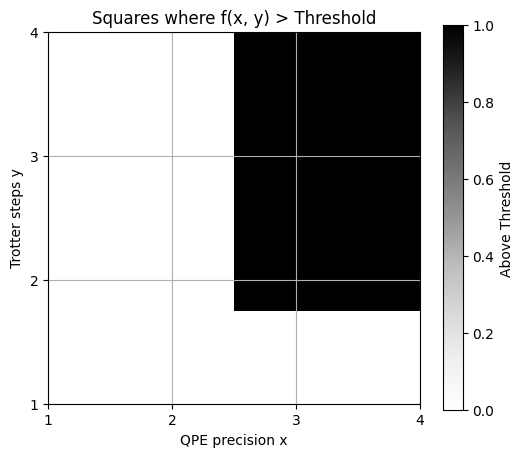

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function f(i, j)
def f(i, j):
    # Ensure i and j are numpy arrays
    i = np.array(i)
    j = np.array(j)
    # Get the shape of the input arrays
    input_shape = i.shape
    # Flatten the arrays
    i_flat = i.flatten()
    j_flat = j.flatten()
    # Retrieve 'F0' values for each (i, j) pair
    f0_values = np.array([results_dict[(i_val, j_val)]['F0'] for i_val, j_val in zip(i_flat, j_flat)])
    # Reshape to match input shape
    return f0_values.reshape(input_shape)

# Define the range for x and y
x = np.arange(1, 5)  
y = np.arange(1, 5)  

# Create a meshgrid
X, Y = np.meshgrid(x, y)

# Apply the function to the grid
Z = f(X, Y)

# Define the threshold
threshold = 0.99

# Create a boolean mask where True if f(x, y) > threshold
mask = Z > threshold

# Plotting
plt.figure(figsize=(6, 5))
plt.imshow(mask, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='Greys')
plt.colorbar(label='Above Threshold')
plt.title('Squares where f(x, y) > Threshold')
plt.xlabel('QPE precision x')
plt.ylabel('Trotter steps y')
plt.xticks(x)
plt.yticks(y)
plt.grid(True)
plt.show()

In [147]:
results_dict[(3,2)]

{'ops': {'u3': 4830, 'cz': 2790},
 'depth': 2964,
 'P0': 0.87429,
 'F0': np.float64(0.999101482701006)}